<a href="https://colab.research.google.com/github/TurkuNLP/textual-data-analysis-course/blob/main/tda_2023_exercises_3_2_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution for task 2 of the 3rd set of exercises

This is a modification of the [basic text classification notebook](https://github.com/TurkuNLP/textual-data-analysis-course/blob/main/text_classification_basic_example.ipynb).

Text other than headers from the original notebook is excluded, and changed points noted in text.

---

## Setup

In [ ]:
!pip install --quiet transformers datasets evaluate

In [ ]:
import datasets
import transformers
import evaluate

from pprint import pprint

In [ ]:
transformers.utils.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()
datasets.disable_progress_bar()

---

## Load dataset

For `positive`/`negative` sentiment classification, we load `imdb` instead of the `emotion` dataset that was used in the original notebook.

In [ ]:
DATASET = 'imdb'

builder = datasets.load_dataset_builder(DATASET)
dataset = datasets.load_dataset(DATASET)

In [ ]:
print(builder.info.description)

Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.


In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


That's quite big, so we'll get rid of the unnecessary `unsupervised` part and randomly downsample the others.

In [ ]:
del dataset['unsupervised']

In [ ]:
dataset = dataset.shuffle(seed=42)
dataset['train'] = dataset['train'].select(range(5000))
dataset['test'] = dataset['test'].select(range(1000))

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


In [ ]:
label_names = dataset['train'].features['label'].names
print('Labels:', label_names)

num_labels = len(label_names)
id2label = { k: v for k, v in enumerate(label_names) }
label2id = { v: k for k, v in enumerate(label_names) }

print('Number of labels:', num_labels)
print('id2label mapping:', id2label)
print('labelid2 mapping:', label2id)

Labels: ['neg', 'pos']
Number of labels: 2
id2label mapping: {0: 'neg', 1: 'pos'}
labelid2 mapping: {'neg': 0, 'pos': 1}


---

## Tokenize and vectorize dataset

To train a multilingual classifier, we'll use `xlm-roberta` instead of `bert`.

In [ ]:
MODEL = 'xlm-roberta-base'

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)

Here we've added `truncation=True` to truncate inputs to the model max length. (This wasn't required in the original code as it used a dataset of tweets, which were all shorter than the max length.) 

In [ ]:
def tokenize(example):
  return tokenizer(example['text'], truncation=True)

dataset = dataset.map(tokenize)

---

## Instantiate model

In [ ]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

---

## Training configuration

In [ ]:
accuracy = evaluate.load('accuracy')

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) # pick index of "winning" label
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
trainer_args = transformers.TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=500,
)

In [ ]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

---

## Train (fine-tune) model

This corpus has no validation set, so we'll evaluate on `test`. (This is poor practice and should be avoided for anything serious.)

In [ ]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_accuracy,
    tokenizer=tokenizer,
    callbacks=[training_logs], 
)

max_steps is given, it will override any value given in num_train_epochs


**Note**: if when running `trainer.train()` you get a confusing error message along the lines of

```
The expanded size of the tensor (596) must match the existing size (514) at non-singleton dimension 1. 
```

This means some examples are too long and you need to add truncation.

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 278045186
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster tha

{'loss': 0.6558, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.16}
{'eval_loss': 0.4956127405166626, 'eval_accuracy': 0.79, 'eval_runtime': 30.9296, 'eval_samples_per_second': 32.331, 'eval_steps_per_second': 1.035, 'epoch': 0.16}


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32


{'loss': 0.4217, 'learning_rate': 6e-06, 'epoch': 0.32}
{'eval_loss': 0.34418126940727234, 'eval_accuracy': 0.873, 'eval_runtime': 31.1192, 'eval_samples_per_second': 32.134, 'eval_steps_per_second': 1.028, 'epoch': 0.32}


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32


{'loss': 0.3658, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.48}
{'eval_loss': 0.3122622072696686, 'eval_accuracy': 0.889, 'eval_runtime': 31.0638, 'eval_samples_per_second': 32.192, 'eval_steps_per_second': 1.03, 'epoch': 0.48}


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32


{'loss': 0.3243, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.64}
{'eval_loss': 0.3339982032775879, 'eval_accuracy': 0.896, 'eval_runtime': 31.159, 'eval_samples_per_second': 32.093, 'eval_steps_per_second': 1.027, 'epoch': 0.64}


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32


{'loss': 0.3387, 'learning_rate': 0.0, 'epoch': 0.8}


Saving model checkpoint to checkpoints/checkpoint-500
Configuration saved in checkpoints/checkpoint-500/config.json


{'eval_loss': 0.3380689024925232, 'eval_accuracy': 0.898, 'eval_runtime': 31.1984, 'eval_samples_per_second': 32.053, 'eval_steps_per_second': 1.026, 'epoch': 0.8}


Model weights saved in checkpoints/checkpoint-500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from checkpoints/checkpoint-500 (score: 0.3380689024925232).


{'train_runtime': 571.3387, 'train_samples_per_second': 7.001, 'train_steps_per_second': 0.875, 'train_loss': 0.42126811218261717, 'epoch': 0.8}


TrainOutput(global_step=500, training_loss=0.42126811218261717, metrics={'train_runtime': 571.3387, 'train_samples_per_second': 7.001, 'train_steps_per_second': 0.875, 'train_loss': 0.42126811218261717, 'epoch': 0.8})

---

## Evaluate trained model

In [ ]:
eval_results = trainer.evaluate(dataset['test'])

pprint(eval_results)

print('\nAccuracy:', eval_results['eval_accuracy'])

The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32


{'eval_loss': 0.3380689024925232, 'eval_accuracy': 0.898, 'eval_runtime': 30.7152, 'eval_samples_per_second': 32.557, 'eval_steps_per_second': 1.042, 'epoch': 0.8}
{'epoch': 0.8,
 'eval_accuracy': 0.898,
 'eval_loss': 0.3380689024925232,
 'eval_runtime': 30.7152,
 'eval_samples_per_second': 32.557,
 'eval_steps_per_second': 1.042}

Accuracy: 0.898


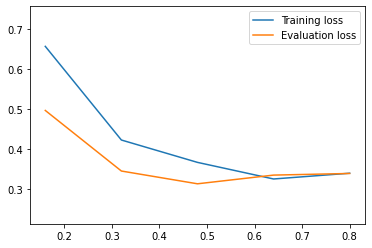

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ['loss', 'eval_loss'], ['Training loss', 'Evaluation loss'])

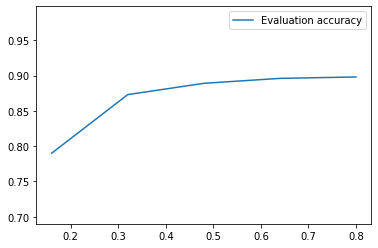

In [ ]:
plot(training_logs.logs, ['eval_accuracy'], ['Evaluation accuracy'])

---

## Create pipeline



We can wrap our fine-tuned model in a pipeline for convenience. (We need to specify `device` here as the model is on GPU.)

In [ ]:
pipe = transformers.pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0
)

Test:

In [ ]:
pipe('Tämä on hyvä.')

[{'label': 'pos', 'score': 0.8573416471481323}]

In [ ]:
pipe("Tämä ei ole hyvä.")

[{'label': 'neg', 'score': 0.8350642919540405}]

In [ ]:
pipe('Tämä elokuva on kertakaikkiaan surkea.')

[{'label': 'neg', 'score': 0.880362331867218}]

In [ ]:
pipe('Ich glaube nicht, dass es bisher einen so schrecklichen Film wie diesen gegeben hat.')

[{'label': 'neg', 'score': 0.6850724220275879}]

In [ ]:
pipe('Ich habe jede Minute davon sehr genossen.')

[{'label': 'pos', 'score': 0.9742209315299988}]

In [ ]:
pipe('この映画は本当に悪いです。')

[{'label': 'neg', 'score': 0.8957082629203796}]

In [ ]:
pipe('これは私が今まで見た中で最高の映画です！')

[{'label': 'pos', 'score': 0.9722869396209717}]